In [5]:
%matplotlib inline
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1次元入力2クラス分類
分類問題では確率の概念が導入される。例えば以下の式のように、入力変数Xを条件とした目標変数T (クラス/カテゴリ/ラベル と呼ばれる) の条件付き確率P(t=1|x)と見なされる。このwを求めるのが分類における学習処理となる。このような確率の概念を導入する事によって予測時の不確実さを定量的に扱うことが可能になる。

$$
\begin{align}
    \boldsymbol{X} = \left[\begin{array}{c}
        x_0 \\ x_1 \\ \vdots \\ x_{N-1}
    \end{array}\right]
    \quad
    \boldsymbol{T} = \left[\begin{array}{c}
        t_0 \\ t_1 \\ \vdots \\ t_{N-1}
    \end{array}\right]
    \quad
    w = P(t=1|x)
\end{align}
$$

## サンプルデータ
昆虫の重量(変数X)で性別(変数T。オス: 1, メス: 0)を推測する。

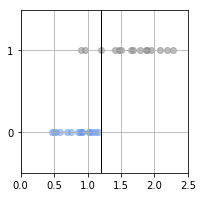

In [6]:
np.random.seed(seed=0)
X_min, X_max, X_n, X_col = 0, 2.5, 30, ["cornflowerblue", "gray"]
X = np.zeros(X_n)
T = np.zeros(X_n, dtype=np.uint8)
Dist_s = [0.4, 0.8]
Dist_w = [0.8, 1.6]
Pi = 0.5

for n in range(X_n):
    wk = np.random.rand()
    T[n] = 0 * (wk < Pi) + 1 * (wk >= Pi)
    X[n] = np.random.rand() * Dist_w[T[n]] + Dist_s[T[n]]

def show_data1(x, t):
    K = np.max(t) + 1
    for k in range(K):
        plt.scatter(x[t==k], t[t==k], c=X_col[k], alpha=0.5)
    plt.grid()
    plt.ylim(-0.5, 1.5)
    plt.xlim(X_min, X_max)
    plt.yticks([0, 1])

plt.figure(figsize=(3, 3))
show_data1(X, T)
plt.axvline(1.2, color="black", lw=1)

## 最尤推定
モデルを作成した場合、現実の観測データとの誤差を最小化するために誤差を定量化する。回帰の際には2乗誤差が使われていたが、分類では **尤度** を用いる。

尤度とはモデルを定義した際、実際の観測データがそのモデルから生成されたものかを確率で表現したものである。仮にT=\[0, 0, 0, 1\]があり、モデルは一様分布、T_i=1となる確率をwとした場合、その尤度は次の式になる。式としては、0が3回連続で出てその後1が1回出る確率の式になる。

$$
\begin{align}
    P(T=0,0,0,1|x) = (1-w)^3w \\
\end{align}
$$

微分で尤度を最大化するwを導出すればwの最適解が分かる。その際、微分時の掛け算の面倒を避けるために式は対数化して扱う。これを **対数尤度** と呼ぶ。下の式ではw=1/4が最適解。

$$
\begin{align}
    \log P
        &= \log \left\{ (1-w)^3w \right\} = 3\log (1-w) + \log w \\
    \frac{\partial}{\partial w}\log P &= 3\frac{-1}{1-w}+\frac{1}{w} = \frac{-3w+1-w}{(1-w)w} \\
\end{align}
$$

※ ちなみに (1-w)の偏微分は合成関数の微分になっている点に注意。

In [9]:
T_yudo = np.array([0, 0, 0, 1])
W_yudo = np.arange(0, 0.5, 0.05)

# w = 0.25で尤度が最大化していることが分かる
print("尤度")
for w in W_yudo:
    print(w.round(2),"\t", repr(np.prod([w if t == 1 else (1-w) for t in T_yudo]).round(3)))

尤度
0.0 	 0.0
0.05 	 0.043
0.1 	 0.073
0.15 	 0.092
0.2 	 0.102
0.25 	 0.105
0.3 	 0.103
0.35 	 0.096
0.4 	 0.086
0.45 	 0.075


## ロジスティック回帰モデル
ここまでは分布を一様分布と仮定してきたが、現実の分布は正規分布を取ることも多い。次の式はロジスティック回帰関数と呼ばれ、分類対象のデータ分布が正規分布を取る場合にその分布の $P(t=1|x)$ はロジスティック回帰モデルで表現できる事が分かっている。この関数はシグモイド関数のパラメータ部分が $w_0x+w_1$ になっており、ここを操作する事で分布の広がりや変化の階調を変えられる。

$$
\begin{align}
    y &= \sigma(w_0x + w_1) = \frac{1}{1 + \exp\left\{-(w_0x + w_1)\right\}} \\
\end{align}
$$

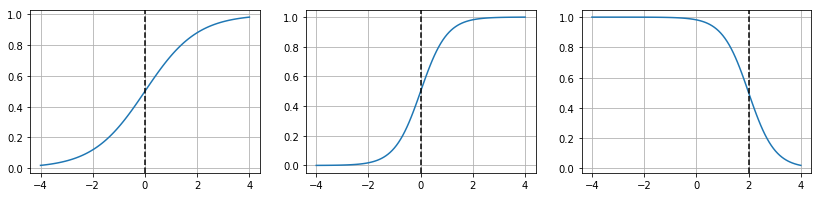

In [3]:
def logistic(x, w):
    y = 1 / (1 + np.exp(-(w[0]*x + w[1])))
    return y
def show_logistic(X_min, X_max, w):
    # 関数本体
    xb = np.linspace(X_min, X_max, 100)
    y = logistic(xb, w)
    plt.plot(xb, y)
    
    # 決定境界 (0.5)
    y_gt05 = y > 0.5
    y_shiftSum = y_gt05[:-1].astype(np.uint) + y_gt05[1::].astype(np.uint)
    i = np.min(np.where(y_shiftSum == 1))
    
    B = (xb[i] + xb[i+1]) / 2
    plt.axvline(B, color="black", linestyle="--")
    plt.grid()
    return B

# 様々な形のシグモイド関数
plt.figure(figsize=(14, 3))
for i, W in enumerate([[1, 0], [2, 0], [-2, 4]]):
    plt.subplot(1, 3, i + 1)
    show_logistic(-4, 4, W)

## 平均交差エントロピー誤差
ロジスティック回帰関数(y)から尤度を導出する式が次の通り。特に(1)は交差エントロピー誤差、(2)は **平均交差エントロピー** と呼ばれる。

$$
\begin{align}
    P(\boldsymbol{T}|\boldsymbol{X})
        &= \prod_{n=0}^{N-1}P(t_n|x_n) = \prod_{n=0}^{N-1}y_n^{t_n}(1-y_n)^{1-t_n} \\
    log P(\boldsymbol{T}|\boldsymbol{X})
        &= \sum_{n=0}^{N-1} \{t_n\log y_n + (1-t_n)\log (1-y_n) \} \tag{1} \\
    E(w)
        &= -\frac{1}{N}\sum_{n=0}^{N-1} \{t_n \log y_n + (1-t_n)\log (1-y_n) \} \tag{2} \\
\end{align}
$$

**※ メモ**  
尤度は下の式のようにすれば対数の必要性は無い。しかし尤度は1以下の数値を複数回掛けるため、コンピュータではアンダーフローの危険がある。そのため、対数を用いたほうがコンピュータには良い。
$$
\begin{align}
    P(\boldsymbol{T}|\boldsymbol{X})
        &= \sum_{n=0}^{N-1}\{t_ny_n + (1-t_n)(1-y_n) \} \\
\end{align}
$$

各w毎の平均交差エントロピー誤差を可視化する。  
w0 = 8, w1 = -10 あたりに尤度最大のポイントがある事が分かる。

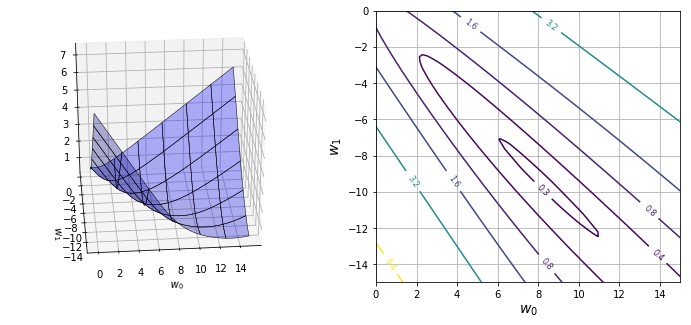

In [7]:
# 平均交差エントロピー誤差
def cee_logistic(w, x, t):
    y = logistic(x, w)
    cee = t*np.log(y) + (1-t)*np.log(1-y)
    cee = -np.mean(cee, axis=0)
    return cee

xn = 60
w_range = np.array([[0, 15], [-15, 0]])
w0 = np.linspace(*w_range[0], xn)
w1 = np.linspace(*w_range[1], xn)

WW0, WW1 = np.meshgrid(w0, w1)
XX = np.repeat(X, xn**2).reshape(-1, xn, xn)
TT = np.repeat(T, xn**2).reshape(-1, xn, xn)
CC = cee_logistic([WW0, WW1], XX, TT)

# 3d
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1, projection="3d")
ax.plot_surface(WW0, WW1, CC, color="blue", edgecolor="black", rstride=10, cstride=10, alpha=0.3, lw=0.5)
ax.set_xlabel("$w_0$")
ax.set_ylabel("$w_1$")
ax.view_init(30, -95)

# 等高線
plt.subplot(1, 2, 2)
cont = plt.contour(WW0, WW1, CC, 20, levels=[0.26, 0.4, 0.8, 1.6, 3.2, 6.4])
cont.clabel(fmt="%1.1f", fontsize=8)
plt.xlabel("$w_0$", fontsize=14)
plt.ylabel("$w_1$", fontsize=14)
plt.grid()

## 数値解導出
平均交差エントロピー誤差は解析解が出せない。よって数値解で出す。ここでは **共役勾配法(CG)** で導出する。導出にはpowell法時と同じく目的関数と初期値、w変数以外の追加パラメータを使う他、勾配ベクトルの導関数が必要。式は次の通り (ロジスティック関数(1)、勾配ベクトル(2))。

$$
\begin{align}
    E &= -\frac{1}{N}\sum_{n=0}^{N-1}\{t_n \log y_n + (1-t_n)\log (1-y_n)\} \tag{1} \\
    \nabla E &=
        \left[\begin{array}{l}
            \frac{1}{N}\sum_{n=0}^N (y_n - t_n)x_n \\
            \frac{1}{N}\sum_{n=0}^N (y_n - t_n) \\
        \end{array}\right] \tag{2} \\
\end{align}
$$

微分は連鎖した4つの式と見なして解いている。
$$
\begin{align}
    E &= \frac{1}{N}\sum_{n=0}^{N-1} A_n \\
    A &= -t_n \log y_n - (1-t_n)\log (1-y_n) \\
    y &= \frac{1}{1 + \exp(-b)} \\
    b &= w_0x + w_1 \\
\end{align}
$$

導関数を求める過程は次の通り。log(1 - y_n)を微分する際に合成関数として扱っていることに注意。

$$
\begin{align}
    \frac{\partial E}{\partial w_i}
        &= \frac{1}{N}\sum_{n=0}^{N-1} \frac{\partial A_n}{\partial w_i} \\\\
    \frac{\partial A_n}{\partial y_n} \frac{\partial y_n}{\partial b_n}
        &= \left( -\frac{t_n}{y_n} + \frac{1 - t_n}{1 - y_n} \right) y_n(1 - y_n) \\
        &= \frac{-t_n(1 - y_n) + y(1 - t_n)}{y_n(1 - y_n)} y_n(1 - y_n) \\
        &= y_n - t_n \\
    \frac{\partial b_n}{\partial w_i}
        &= \begin{cases} x_n & i = 0 \\ 1 & {\rm otherwise} \end{cases} \\
\end{align}
$$

     fun: 0.2510446337942387
     jac: array([ 4.28508959e-06, -1.59777250e-07])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 12
    njev: 36
  status: 0
 success: True
       x: array([ 8.17647664, -9.3822462 ])


Text(0.5,1,'$w_0=8.18 \\quad w_1=-9.38 \\quad cee=0.25 \\quad b=1.15$')

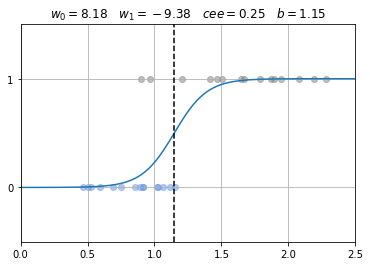

In [160]:
# 平均交差エントロピー誤差 偏微分
def dcee_logistic(w, x, t):
    y = logistic(x, w)
    dw0 = (y - t) * x
    dw1 = (y - t)
    dw = np.array([dw0, dw1])
    dw = np.mean(dw, axis=1)
    return dw
def fit_logistic(w_init, x, t):
    res1 = opt.minimize(cee_logistic, w_init, args=(x, t), jac=dcee_logistic, method="CG")
    print(res1)
    return res1.x

W_init = [1, -1]
W = fit_logistic(W_init, X, T)
c = cee_logistic(W, X, T)
b = show_logistic(X_min, X_max, W)
show_data1(X, T)
plt.title("$w_0={0:.2f} \quad w_1={1:.2f} \quad cee={2:.2f} \quad b={3:.2f}$".format(*W, c, b))

# 2次元入力2クラス分類
ここまでは1次元入力から2クラスへの分類を行っていた。ここでは2次元以上の入力から2クラスへの分類を行う。

## サンプルデータ
データは1次元にデータの数、2次元にクラスが来ている。クラスは該当するクラスが1、それ以外が0を取る。このような表記を **1-of-K符号化** と呼ぶ。

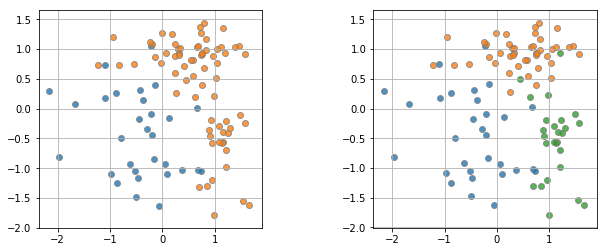

In [161]:
np.random.seed(seed=1)
N, K = 100, 3

# クラス値T生成 (3クラス分類)
Mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1.0, -0.5]])  # 分布の中心
Sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])  # 分布の分散
Pi = np.array([0.4, 0.8, 1.0])  # (A) 各分布への割合 0.4 0.8 1
wk = np.random.rand(N)

T3 = np.zeros((N, 3), dtype=np.uint8)
T2 = np.zeros((N, 2), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
np.random.seed(seed=1)  # 乱数を固定
for n in range(N):
    wk = np.random.rand()
    for k in range(K): # (B)
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])
T2[:, 0] = T3[:, 0]
T2[:, 1] = T3[:, 1] | T3[:, 2] 

# # クラス値T生成 (3クラス分類)
# T3 = np.zeros((N, 3), dtype=np.uint8)
# T3[(0.0 <= wk) & (wk < 0.4),0] = 1
# T3[(0.4 <= wk) & (wk < 0.8),1] = 1
# T3[(0.8 <= wk) & (wk < 1.0),2] = 1

# # クラス値T生成 (2クラス分類)
# T2 = np.zeros((N, 2), dtype=np.uint8)
# T2[:,0] = T3[:,0]
# T2[:,1] = T3[:,1] | T3[:,2]

# # クラス値Tから入力変数Xを生成
# X_range0 = [-3, 3]
# X_range1 = [-3, 3]
# X = np.zeros((N, 2))
# X[:,0] = np.sum(np.random.randn(N, 1) * Sig.T[0] * T3 + Mu.T[0] * T3, axis=1)
# X[:,1] = np.sum(np.random.randn(N, 1) * Sig.T[1] * T3 + Mu.T[1] * T3, axis=1)

# 可視化
def show_data2(x, t):
    for k in range(t.shape[1]):
        plt.grid(True)
        plt.scatter(
            x[t[:, k] == 1, 0],
            x[t[:, k] == 1, 1], edgecolor="gray", alpha=0.8)

plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
show_data2(X, T2)
plt.subplot(1, 2, 2)
show_data2(X, T3)

## 2変数版のロジスティック関数
シグモイド関数のパラメータ部分の多項式に変数が追加される。

$$
\begin{align}
    y &= \sigma(w_0x_0 + w_1x_1 + w_2) = \frac{1}{1 + \exp \{-(w_0x_0 + w_1x_1 + w_2) \}} \\
\end{align}
$$

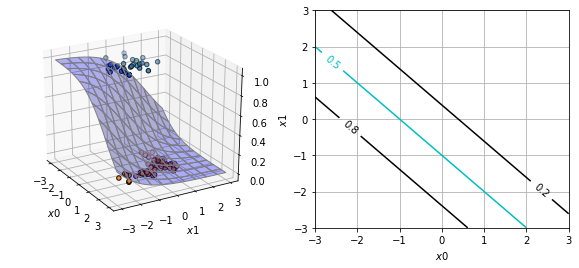

In [162]:
def logistic2(x0, x1, w):
    y = 1 / (1 + np.exp(-(w[0]*x0 + w[1]*x1 + w[2])))
    return y
def show_logistic2(ax, w, t):
    # ロジスティック関数の形状をプロット
    xn = 50
    x0 = np.linspace(*X_range0, xn)
    x1 = np.linspace(*X_range1, xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    ax.plot_surface(xx0, xx1, y, color="blue", edgecolor="gray", rstride=5, cstride=5, alpha=0.3)
    ax.set_xlabel("$x0$")
    ax.set_ylabel("$x1$")
    ax.view_init(elev=25, azim=-30)
    
    # 個々のデータをプロット
    c = [[0.5, 0.5, 0.5], [1.0, 1.0, 1.0]]
    ax.scatter(X[t[:, 0] == 1, 0], X[t[:, 0] == 1, 1], 1, edgecolor="black")
    ax.scatter(X[t[:, 1] == 1, 0], X[t[:, 1] == 1, 1], 0, edgecolor="black")
    return
def show_contour_logistic2(w):
    xn = 30
    x0 = np.linspace(*X_range0, xn)
    x1 = np.linspace(*X_range1, xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    c = plt.contour(xx0, xx1, y, levels=(0.2, 0.5, 0.8), colors=("k", "c", "k"))
    c.clabel(fmt="%1.1f", fontsize=10)
    plt.xlabel("$x0$")
    plt.ylabel("$x1$")
    plt.grid()

W = [-1, -1, -1]
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1, projection="3d")
show_logistic2(ax, W, T2)

plt.subplot(1, 2, 2)
plt.margins(0.1, 0.1)
show_contour_logistic2(W)

## 2変数版勾配ベクトル
2変数版ロジスティック関数の勾配ベクトルは次の通り。1変数版ロジスティック関数の偏微分結果から、末尾のシグモイド関数のパラメータ部分の偏微分を変えてやれば良い。
$$
\begin{align}
    \frac{\partial E}{\partial w_0} &= \frac{1}{N}\sum_{n=0}^N (y_n - t_n)x_0 \\
    \frac{\partial E}{\partial w_1} &= \frac{1}{N}\sum_{n=0}^N (y_n - t_n)x_1 \\
    \frac{\partial E}{\partial w_2} &= \frac{1}{N}\sum_{n=0}^N (y_n - t_n) \\
\end{align}
$$

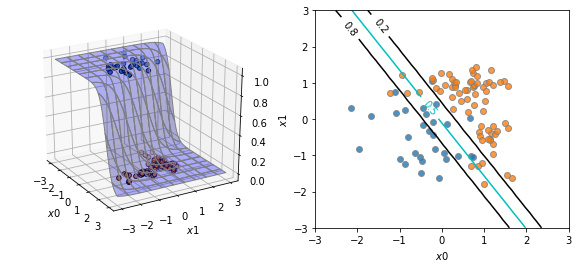

In [163]:
def cee_logistic2(w, x, t):
    X_n = x.shape[0]
    y = logistic2(x[:,0], x[:,1], w)
    cee = np.mean(-(t[:,0] * np.log(y) + (1 - t[:,0]) * np.log(1 - y)))
    return cee
def dcee_logistic2(w, x, t):
    y = logistic2(x[:,0], x[:,1], w)
    dceeA = (y - t[:,0]) * x[:,0]
    dceeB = (y - t[:,0]) * x[:,1]
    dceeC = (y - t[:,0])
    dcee = np.array([dceeA, dceeB, dceeC])
    dcee = np.mean(dcee, axis=1)
    return dcee
def fit_logistic2(w_init, x, t):
    res = opt.minimize(cee_logistic2, w_init, args=(x, t), jac=dcee_logistic2, method="CG")
    return res.x

W = fit_logistic2([-1, 0, 0], X, T2)
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1, projection="3d")
show_logistic2(ax, W, T2)

plt.subplot(1, 2, 2)
show_data2(X, T2)
show_contour_logistic2(W)

# 2次元入力3クラス分類
## 3クラス分類のロジスティック関数
今までシグモイド関数を使用していたが、ソフトマックス関数(y)を使うことで複数クラス分類へ対応させることができる。その際はロジスティック関数をクラスの数だけ用意する(k)。ソフトマックス関数の性質上、sum(y_k) = 1 が成り立ち、それぞれのクラスに属する確率が導出できる。

$$
\begin{align}
    a_k &= \sum_{i=0} w_{ki}x_i \\
    y_k &= \frac{\exp(a_k)}{\sum_{i=0}\exp(a_i)}
\end{align}
$$

In [164]:
def logistic3(x, w):
    n, d = x.shape[0], x.shape[1] + 1
    w = w.reshape((-1, d))              # w: [a]      -> [class][x_i]
    x = np.hstack((x, np.ones((n, 1)))) # x: [n][x_i] -> [n][x_i][1]
    x = x.reshape((-1, d, 1))
    
    y = w @ x
    y = np.exp(y)
    u = np.sum(y, axis=1, keepdims=True)
    y = y / u
    y = y.reshape((-1, d))
        
    return y

# 動作確認
np.round(logistic3(X[:5], np.arange(1, 10)), 3)

array([[0.   , 0.006, 0.994],
       [0.965, 0.033, 0.001],
       [0.925, 0.07 , 0.005],
       [0.   , 0.   , 1.   ],
       [0.019, 0.126, 0.856]])

## 平均交差エントロピー誤差
平均交差エントロピー誤差は次の通り。

$$
\begin{align}
    P(T|X) &= y_0^{t_0} y_1^{t_1} y_2^{t_2}
            = \prod_{n=0} y_{n0}^{t_{n0}} y_{n1}^{t_{n1}} y_{n2}^{t_{n2}}
            = \prod_{n=0}\prod_{k=0} y_{nk}^{t_{nk}} \\
    E(W)   &= -\frac{1}{N} \sum_{n=0}\sum_{k=0} t_{nk}\log y_{nk}
\end{align}
$$

## 勾配ベクトル
勾配ベクトルは次の通り。微分手順は次の章でやるそうな。下は行列計算に変換したもの (縦: データ数、横: 入力変数)。

$$
\begin{align}
    \frac{\partial E}{\partial w_{ki}}
        &= \frac{1}{N}\sum_{n=0}(y_{nk} - t_{nk})x_{ni} \\
        &= \frac{1}{N} ({\bf y}_n - {\bf t}_n)^T {\bf x}_n
\end{align}
$$

In [170]:
def cee_logistic3(w, x, t):
    X_n = x.shape[0]
    y = logistic3(x, w)
    cee = t * np.log(y)
    cee = -np.sum(cee) / X_n
    return cee
def dcee_logistic3(w, x, t):
    n = x.shape[0]
    y = logistic3(x, w)
    x = np.hstack((x, np.ones((n, 1))))
    
    a = y - t
    a = a.T
    dcee = a @ x
    dcee = dcee / n
    dcee = dcee.flatten()
    return dcee
# 動作確認
print(repr(dcee_logistic3(np.arange(1, 10), X, T3)))

def fit_logistic3(w_init, x, t):
    res = opt.minimize(cee_logistic3, w_init, args=(x, t), jac=dcee_logistic3, method="CG")
    return res.x
# 動作確認
print(repr(fit_logistic3(np.zeros((3, 3)), X, T3)))

array([ 0.03778433,  0.03708109, -0.1841851 , -0.21235188, -0.44408101,
       -0.38340835,  0.17456754,  0.40699992,  0.56759346])
array([-3.19587417, -2.68944532,  2.2536977 , -0.48737939,  4.80192239,
       -0.69084022,  3.68325356, -2.11247707, -1.56285749])


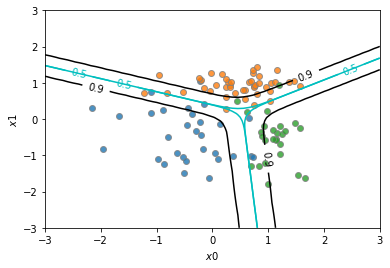

In [171]:
def show_contour_logistic3(w):
    xn = 60
    x0 = np.linspace(*X_range0, xn)
    x1 = np.linspace(*X_range1, xn)
    
    xx0, xx1 = np.meshgrid(x0, x1)
    xx = np.array([xx0.flatten(), xx1.flatten()]).T
    yy = logistic3(xx, w)
    yy = yy.reshape((xn, xn, 3))
    for k in range(3):
        c = plt.contour(xx0, xx1, yy[:,:,k], levels=(0.5, 0.9), colors=("c", "k"))
        c.clabel(fmt="%1.1f", fontsize=10)
        
    plt.xlabel("$x0$")
    plt.ylabel("$x1$")
    plt.grid()

W_init = np.zeros((3, 3))
W = fit_logistic3(W_init, X, T3)
show_data2(X, T3)
show_contour_logistic3(W)